In [19]:
from d2l import torch as d2l
import torch
import math
import numpy as np
from torch import nn

In [20]:
'''生产数据集'''
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.3516],
         [1.2772]]),
 tensor([[1.0000e+00, 3.5162e-01, 6.1817e-02, 7.2453e-03, 6.3690e-04, 4.4789e-05,
          2.6247e-06, 1.3184e-07, 5.7948e-09, 2.2639e-10, 7.9604e-12, 2.5446e-13,
          7.4559e-15, 2.0166e-16, 5.0649e-18, 1.1873e-19, 2.6092e-21, 5.3966e-23,
          1.0542e-24, 1.9509e-26],
         [1.0000e+00, 1.2772e+00, 8.1565e-01, 3.4725e-01, 1.1088e-01, 2.8324e-02,
          6.0293e-03, 1.1001e-03, 1.7563e-04, 2.4925e-05, 3.1835e-06, 3.6964e-07,
          3.9342e-08, 3.8653e-09, 3.5263e-10, 3.0026e-11, 2.3969e-12, 1.8008e-13,
          1.2778e-14, 8.5895e-16]]),
 tensor([5.3779, 5.7021]))

In [21]:
'''训练'''
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = d2l.reshape(y, out.shape)
        l = loss(out, y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),batch_size, is_train=False)

    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',xlim=[1, num_epochs], ylim=[1e-3, 1e2],legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


weight: [[ 5.0041194  1.2299188 -3.38337    5.570715 ]]


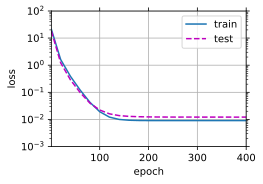

In [22]:
'''三阶多项式函数拟合(正态)'''
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])


weight: [[3.4506414 3.7441273]]


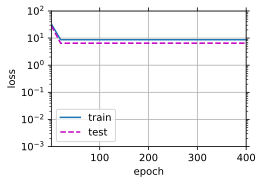

In [23]:
'''线性函数拟合(欠拟合)'''
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.98538256e+00  1.35240805e+00 -3.27204347e+00  4.99916029e+00
  -3.19588840e-01  1.23218799e+00  1.01605259e-01  3.38905394e-01
  -1.65731639e-01 -9.91780311e-02  3.66201960e-02  1.23644797e-02
  -3.83657254e-02  1.71127185e-01 -3.07310540e-02 -4.28962670e-02
  -1.79493874e-01  1.65261194e-01 -1.14639006e-04  2.00368360e-01]]


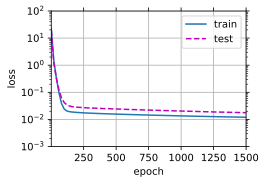

In [24]:
'''高阶多项式函数拟合(过拟合)'''
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)
